In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/XBTUSD-1d-data.csv', parse_dates=[0])
df.head()

,timestamp,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
0,2015-09-26 00:00:00+00:00,XBTUSD,239.99,239.99,234.81,235.20,153,190090,235.910,24,44844188670,448.441887,105792.660735
1,2015-09-27 00:00:00+00:00,XBTUSD,235.20,235.36,232.91,234.51,146,258488,233.990,200,60483729840,604.837298,141526.710902
2,2015-09-28 00:00:00+00:00,XBTUSD,234.51,234.76,233.03,233.29,101,161013,233.550,1000,37604645900,376.046459,87825.998859
3,2015-09-29 00:00:00+00:00,XBTUSD,233.29,243.19,232.90,240.07,262,319143,237.981,50,75949944400,759.499444,180755.759328
4,2015-09-30 00:00:00+00:00,XBTUSD,240.07,241.50,235.81,237.00,285,368771,238.266,9000,87865511830,878.655118,209360.657739


In [ ]:
df = df.drop_duplicates(subset="timestamp", keep="first")
df = df.set_index("timestamp").sort_index()
df.head()

,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
timestamp,,,,,,,,,,,,
2015-09-26 00:00:00+00:00,XBTUSD,239.99,239.99,234.81,235.20,153,190090,235.910,24,44844188670,448.441887,105792.660735
2015-09-27 00:00:00+00:00,XBTUSD,235.20,235.36,232.91,234.51,146,258488,233.990,200,60483729840,604.837298,141526.710902
2015-09-28 00:00:00+00:00,XBTUSD,234.51,234.76,233.03,233.29,101,161013,233.550,1000,37604645900,376.046459,87825.998859
2015-09-29 00:00:00+00:00,XBTUSD,233.29,243.19,232.90,240.07,262,319143,237.981,50,75949944400,759.499444,180755.759328
2015-09-30 00:00:00+00:00,XBTUSD,240.07,241.50,235.81,237.00,285,368771,238.266,9000,87865511830,878.655118,209360.657739


In [ ]:
df.index[0:10]

DatetimeIndex(['2015-09-26 00:00:00+00:00', '2015-09-27 00:00:00+00:00',
               '2015-09-28 00:00:00+00:00', '2015-09-29 00:00:00+00:00',
               '2015-09-30 00:00:00+00:00', '2015-10-01 00:00:00+00:00',
               '2015-10-02 00:00:00+00:00', '2015-10-03 00:00:00+00:00',
               '2015-10-04 00:00:00+00:00', '2015-10-05 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='timestamp', freq=None)

In [ ]:
df = df[['open', 'high', 'low', 'close', 'volume']]
df.head()

,open,high,low,close,volume
timestamp,,,,,
2015-09-26 00:00:00+00:00,239.99,239.99,234.81,235.20,190090
2015-09-27 00:00:00+00:00,235.20,235.36,232.91,234.51,258488
2015-09-28 00:00:00+00:00,234.51,234.76,233.03,233.29,161013
2015-09-29 00:00:00+00:00,233.29,243.19,232.90,240.07,319143
2015-09-30 00:00:00+00:00,240.07,241.50,235.81,237.00,368771


In [ ]:
df['open'] = df['open'].fillna(method='bfill')
df['high'] = df['high'].fillna(method='bfill')
df['low'] = df['low'].fillna(method='bfill')
df['close'] = df['close'].fillna(method='bfill')
df['volume'] = df['volume'].fillna(value=0)

In [ ]:
df = df.dropna()

In [ ]:
#create new index
data_idx = pd.date_range(start=df.index[0], end=df.index[-1], freq='D')
df = df.reindex(data_idx, method="bfill")
df = df.sort_index(ascending=True)
df.head()

,open,high,low,close,volume
2015-09-26 00:00:00+00:00,239.99,239.99,234.81,235.20,190090
2015-09-27 00:00:00+00:00,235.20,235.36,232.91,234.51,258488
2015-09-28 00:00:00+00:00,234.51,234.76,233.03,233.29,161013
2015-09-29 00:00:00+00:00,233.29,243.19,232.90,240.07,319143
2015-09-30 00:00:00+00:00,240.07,241.50,235.81,237.00,368771


In [ ]:
# df = df['close']
# df.head()
print(df[0:4])

                             open    high     low   close  volume
2015-09-26 00:00:00+00:00  239.99  239.99  234.81  235.20  190090
2015-09-27 00:00:00+00:00  235.20  235.36  232.91  234.51  258488
2015-09-28 00:00:00+00:00  234.51  234.76  233.03  233.29  161013
2015-09-29 00:00:00+00:00  233.29  243.19  232.90  240.07  319143


In [ ]:

def normalize_zero_base(df):
  return df / df.iloc[0] - 1


def extract_window_data(df, window):
  data = []
  for idx in range(len(df)-window):
    tmp = df[idx:(idx+window)].copy()
    tmp = normalize_zero_base(tmp)
    data.append(tmp.values)
  return np.array(data)


def prepare_data(df, window=15, test_size=0.2):
  split_row = len(df) - int(test_size * len(df))
  train_data = df.iloc[:split_row]
  test_data = df.iloc[split_row:]

  x_train = extract_window_data(train_data, window)
  x_test = extract_window_data(test_data, window)

  y_train = train_data['close'][window:].values
  y_test = test_data['close'][window:].values

  y_train = y_train / train_data["close"][:-window].values - 1
  y_test = y_test / test_data["close"][:-window].values - 1

  return train_data, test_data, x_train, y_train, x_test, y_test


train_df, test_df, x_train, y_train, x_test, y_test = prepare_data(df, window=15, test_size=0.2)

In [ ]:
y_train[0]

0.04591836734693877

In [ ]:
window = 15
dropout = 0.2
epochs = 20
loss = 'mse'
optimizer = 'adam'
batch_size = 32

model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=100, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units=1))
model.add(keras.layers.Activation('linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss=loss, optimizer=optimizer)

In [ ]:
y_train.shape
x_train.shape

(1354, 15, 5)

In [ ]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
43/43 [==============================] - 7s 7ms/step - loss: 0.0185
Epoch 2/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0077
Epoch 3/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0064
Epoch 4/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0057
Epoch 5/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0050
Epoch 6/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0047
Epoch 7/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 8/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0043
Epoch 9/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 10/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 11/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 12/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 13/20
43/43 [==============================

In [ ]:
preds = model.predict(x_test).squeeze()
preds = test_df['close'].values[:-window] * (preds + 1)


In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
print(mean_absolute_error(preds, y_test))


8687.602645746421


<function matplotlib.pyplot.show>

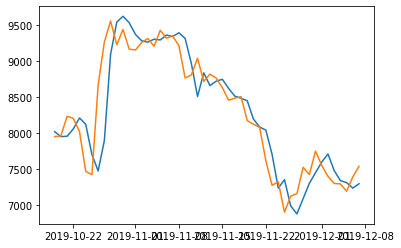

In [ ]:
import matplotlib.pyplot as plt

targets = test_df['close'][window:]
preds = pd.Series(index=targets.index, data=preds)

fig, ax = plt.subplots(1)
ax.plot(preds[100:150], label='output')
ax.plot(targets[100:150], label='target')
plt.show